## Exercise 1
The first part of this assignment consists in studying a single particle performing
a continuous-time random walk in the network described by the graph in Fig. 1 and with the
following transition rate matrix:


$$
\Lambda = 
\begin{bmatrix} 0  & 2/5 & 1/5 & 0   & 0  \\
                  0  & 0   & 3/4 & 1/4 & 0  \\
                 1/2 & 0   &  0  & 1/2 & 0  \\
                  0  & 0   & 1/3 & 0   & 2/3\\
                  0  & 1/3 & 0   & 1/3 & 0  \end{bmatrix}$$

In [1]:
%matplotlib inline
import networkx as nx 
import numpy as np 
import matplotlib.pyplot as plt
import random
from numpy.random import choice, rand 
import matplotlib.pyplot as plt

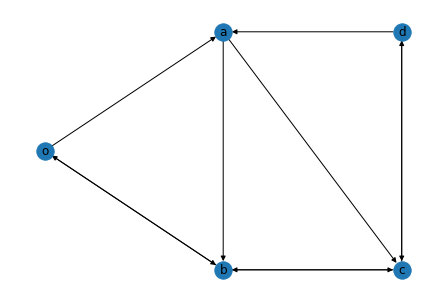

In [2]:
G_labelled = nx.DiGraph()
G_labelled.add_edges_from([('o','a'),('o','b'),('a','b'),('a','c'),('b','o'),('b','c'),('c','b'),('c','d'),('d','a'),('d','c')])
pos = {'o':[-1,0], 'a':[0,1], 'b':[0,-1], 'd':[1,1], 'c':[1,-1]}

nx.draw(G_labelled,pos, with_labels = True)

In [4]:
mapping = {'o': 0, 'a':1 , 'b':2, 'c':3 ,'d':4}
G = nx.relabel_nodes(G_labelled, mapping)

Lambda = [
[0, 2/5, 1/5, 0, 0 ],
[0, 0, 3/4, 1/4, 0 ],
[1/2, 0, 0, 1/2, 0 ],
[0, 0, 1/3, 0 ,2/3 ],
[0, 1/3, 0, 1/3, 0 ]]

w = np.sum(Lambda, axis=1)

# compute the jump chain matrix Q
w_star = np.max(w)
# compute the off-diagonal part of Q
Q = Lambda/w_star 
# add the diagonal part
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))

# compute P the normalized weight matrix 
D = np.diag(w)
P = np.linalg.inv(D) @ Lambda

nstates = len(P)

### exercise1.1

Simulated return time

In [5]:
#global clock with rate w_star and matrix Q

# set the number of steps in the simulation
n_steps = 20000
# pos will keep trace of the visited states
pos = -np.ones(n_steps, dtype=int)
# we start from node a 
pos[0] = 1
# transition_times will store the time instants at which
# jumps/transitions happen
transition_times = np.zeros(n_steps)
# the random time to wait for the next transition
# is drawn according to its distribution, discussed in Remark 1
# NOTE: in the formula for t_next we use w_star, the rate of the
# "global" Poisson clock
t_next = -np.log(np.random.rand())/w_star

for i in range(1,n_steps):
    # the next state to visit will be extracted according to the probabilities
    # stored in the row of Q corresponding to the current state.
    # In general, to extract a value pos[i] in (0,...,num_states-1) according to the discrete
    # distribution Q[pos[i-1],:], we use the function random.choice
    pos[i] = np.random.choice(nstates, p=Q[pos[i-1],:])
    # add the new time instant at which we have the jump
    transition_times[i] = transition_times[i-1] + t_next
    # compute the waiting time to the next transition
    t_next = -np.log(np.random.rand())/w_star

# Estimate pi

pi_estimate = np.zeros(nstates)
# We have the time instants of all transitions, we now compute time intervals.
# np.diff computes the n-th discrete difference of a vector.
# Here we set n=1 to compute first difference, which is given by 
# intervals[i] = transition_times[i+1] - transition_times[i].
# We also provide a value to  append to transition_times prior to performing the difference
# so that we can compute also the last interval: 
# transition_times[-1] + t_next is the end of the time horizon.
intervals = np.diff(transition_times, n=1, append = transition_times[-1] + t_next)

# for each state in the state space
for state in range(nstates):
    # identify the steps when we visited that state during the process
    visits = np.argwhere(pos == state)
    # the estimate of the invariant measure for that state is equal to the
    # time spent on the state divided the total time of the process
    pi_estimate[state] = np.sum(intervals[visits])/(transition_times[-1] + t_next)
    
print("Estimate of pi_bar:", pi_estimate)
print(f'estimate of return time in node a is : {1/(w[1]*pi_estimate[1])}')
print(f'timing : {transition_times[-1]}')

Estimate of pi_bar: [0.18190769 0.15107729 0.22251525 0.21491322 0.22958655]
estimate of return time in node a is : 6.619128432990995
timing : 19933.21717993871


### exercise 1.2

Theoretical return time $E_a[T_a^+]$

In [6]:
# compute dominant eigenvector
values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

nstates = len(pi_bar)
print(f'exact calculation of return time in node a is :{1/(w[1]*pi_bar[1])}')

pi_bar= [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]
exact calculation of return time in node a is :6.750000000000008


### exercise 1.3

Simulate average hitting time from o to d : $E_o[T_d]$

In [7]:
# global clock with rate w_star and matrix Q
# set the number of simulation 
n_steps = 20000
# transition_collect will collect all the time intervals used to arrive from node o to node d
transition_collect = []
for i in range(n_steps):
    # transition_times will store the time required to arrive from node o to node d
    transition_time = 0
    # we always start from node 0
    start = 0
    
    while True:
        # the random time to wait for the next transition
        t_next = -np.log(np.random.rand())/w_star
        # update the transition time 
        transition_time += t_next
        # the next state to visit will be extracted according to the probabilities
        # stored in the row of Q corresponding to the current state.
        # In general, to extract a value pos[i] in (0,...,num_states-1) according to the discrete
        # distribution Q[pos[i-1],:]
        next_node = np.random.choice(nstates, p=Q[start,:])
        if next_node == 4: 
            # if we arrived in node d, we append the transition_time and we complete one iteration
            transition_collect.append(transition_time)
            break
        # otherwise we continue our path towards node d
        start = next_node
        
# In order to obtain an average value, we sum the time and divide it by the number of simulations
res = np.array(transition_collect).sum()
print(f'hitting time from node 0 to node 4 is : {res/len(transition_collect)}')


hitting time from node 0 to node 4 is : 8.781657170177539


### exercise 1.4

Theoretical average hitting time from o to d

In [8]:
n_nodes = G.number_of_nodes()

# Define the set S and the remaining nodes R
# Subtract -1 because indexes go from 0 to 5 and nodes from 1 to 6
S = [4] # refer to nodes 4
R = [node for node in range(n_nodes) if node not in S]

# Restrict P to R x R to obtain hat(P)
hatP = P[np.ix_(R, R)]
hatw = w[np.ix_(R)]

# solve the linear system to obtain hat(x)
# np.linalg.solve solves a linear matrix equation given
# the coefficient matrix and the dependent variable values
hatx = np.linalg.solve(np.identity(n_nodes-1) - hatP, 1/hatw)

# define the hitting times to the set S
# hitting time is 0 if the starting node is in S
hitting_s = np.zeros(n_nodes)
# hitting time is hat(x) for nodes in R
for r in R:
    hitting_s[r] = hatx[r]

print("hitting times:", hitting_s)

hitting times: [8.78571429 7.14285714 7.07142857 3.35714286 0.        ]


### exercise 1.5

Interpret the matrix Λ as the weight matrix of a graph G = (V, E,Λ), and simulate the French-DeGroot dynamics on G with an arbitrary initial condition x(0). Does the dynamics converge
to a consensus state for every initial condition x(0)? Motivate your answer

In [9]:
# check if graph G is aperiodic
nx.is_aperiodic(G)

True

In [10]:
# check if graph G is strongly connected
nx.is_strongly_connected(G)

True

Since G is aperiodic and strongly connected, then $x(t) = P^tx(0)$ and 
$$\lim_{t->inf} x(t) = \alpha 1 $$
where  $\alpha = \pi'x(0)$ 

So we can already say that all opinions converges to a common value called CONSENSUS which is $\alpha$ and depends on the initial value of $x(0)$

In [12]:
## since the normalized weight matrix P is already constructed from previous points, we use the same one 

x_init = np.array([0,1,1,0,1])
x = x_init
# simulate the French-De Groot dynamics for t = 50
for i in range(50):
    x = P @ x

print(f'the final result of the dynamics is : {x}')

# compute the dominant eigenvector 
values,vectors = np.linalg.eig(P.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print(f'the invariant distribution of G is : {pi_bar}')
# compute the theoretical value as cited by the theorem
print(f'theorical value alpha : {pi_bar @ x_init.T}')

the final result of the dynamics is : [0.60869562 0.60869493 0.60869717 0.60869332 0.60869761]
the invariant distribution of G is : [0.13043478 0.17391304 0.26086957 0.26086957 0.17391304]
theorical value alpha : 0.6086956521739132


### exercise 1.6

Assume that the initial state of the dynamics for each node i ∈ V is given by $x_i(0) = \xi_i$, where ${\xi_i}, i \in V$ are i.i.d random variables with variance $\sigma^2$ . Compute the variance of the consensus value, and compare your results with numerical simulations.

In [14]:
x_init = np.random.rand(5) # suppose x - U[0,1] --> var(X) = 1/12
print(f'initial state : {x_init}')

# compute the French-De Groot dynamics for t = 100
x = x_init
for i in range(100):
    x = P @ x

var = np.var(x)
print(f'theorethical variance : {1/12}')
print(f'consensus variance : {var} with state : {x}')
print(f'theorical value alpha : {pi_bar @ x_init.T}')

initial state : [0.21045161 0.67330248 0.44617619 0.88524113 0.07212659]
theorethical variance : 0.08333333333333333
consensus variance : 6.165054044046485e-24 with state : [0.50441631 0.50441631 0.50441631 0.50441631 0.50441631]
theorical value alpha : 0.504416305728563


We can notice that the consensus variance is smaller than the theorethical variance -> the crowd decides on a particular consensus value 

### exercise 1.7

Remove the edges (d, a) and (d, c). Describe and motivate the asymptotic behaviour of the dynamics. If the dynamics converges to a consensus state, how is the consensus value related to the initial condition x(0)? Assume that the initial state of the dynamics for each node $i \in V$ is given by $x_i(0) = \xi_i$, where ${\xi_i}, i \in V $are i.i.d random variables with variance $\sigma^2$.
Compute the variance of the consensus value. Motivate your answer.


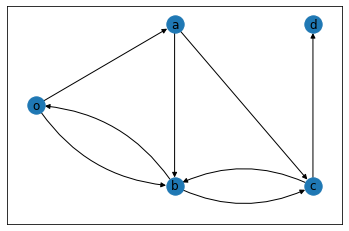

In [15]:
# create a new graph G_new without the edges (d,a) and (d,c)
G_new = nx.DiGraph()
G_new.add_edges_from([('o','a'),('o','b'),('a','b'),('a','c'),('b','o'),('b','c'),('c','b'),('c','d')])
pos = {'o':[-1,0], 'a':[0,1], 'b':[0,-1], 'd':[1,1], 'c':[1,-1]}

fig_1_7, ax_new = plt.subplots()
nx.draw_networkx_nodes(G_new, pos, ax=ax_new)
nx.draw_networkx_labels(G_new, pos, ax=ax_new)
curved_edges = [edge for edge in G_new.edges() if reversed(edge) in G_new.edges()]
straight_edges = list(set(G_new.edges()) - set(curved_edges))
nx.draw_networkx_edges(G_new, pos, ax=ax_new, edgelist=straight_edges)
arc_rad = 0.25
nx.draw_networkx_edges(G_new, pos, ax=ax_new, edgelist=curved_edges, connectionstyle=f'arc3, rad = {arc_rad}')

#fig_1_7.savefig("Exercise1_g.png")

In [16]:
# check if aperiodic
nx.is_aperiodic(G_new)

True

In [17]:
# check if strongly connected
nx.is_strongly_connected(G_new)

False

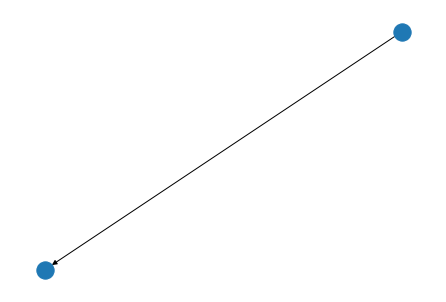

In [18]:
# draw the condensation graph 
CG = nx.algorithms.components.condensation(G_new)

nx.draw(CG)

plt.savefig("Condensategraph1_g.png", format="PNG")

But from the graph we can see that there's a sink (node d is a sink)
In this case $\pi$ has support only on the globally reachable component. The opinions of agents not belonging to the globally reachable component have no influence on the final consensus value 

In [19]:
# the new Lambda should be updated 
Lambda_new = [
[0, 2/5, 1/5, 0, 0 ], # o
[0, 0, 3/4, 1/4, 0 ], # a
[1/2, 0, 0, 1/2, 0 ], # b
[0, 0, 1/3, 0 ,2/3 ], # c
[0, 0, 0, 0, 1 ]] # d

# compute the weights
w_new = np.sum(Lambda_new, axis=1)

# compute the new normalized weight matrix P_new
D_new = np.diag(w_new)
P_new = np.linalg.inv(D_new) @ Lambda_new

In [20]:
# we use P_new to run the dynamics 

x_init = np.array([0,1,1,0,1])
x = x_init
# simulate the French-De Groot dynamics for t = 100
for i in range(100):
    x = P_new @ x

print(f'the final result of the dynamics is : {x}')

# compute the dominant eigenvector 
values,vectors = np.linalg.eig(P_new.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print(f'the invariant distribution of G is : {pi_bar}')
# compute the theoretical value as cited by the theorem
print(f'theorical value alpha : {pi_bar @ x_init.T}')

the final result of the dynamics is : [1. 1. 1. 1. 1.]
the invariant distribution of G is : [0. 0. 0. 0. 1.]
theorical value alpha : 1.0


In [21]:
# we use P_new to run the dynamics 

x_init = np.array([0,1,1,1,0]) # different starting condition x(0)
x = x_init
# simulate the French-De Groot dynamics for t = 100
for i in range(100):
    x = P_new @ x

print(f'the final result of the dynamics is : {x}')

# compute the dominant eigenvector 
values,vectors = np.linalg.eig(P_new.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print(f'the invariant distribution of G is : {pi_bar}')
# compute the theoretical value as cited by the theorem
print(f'theorical value alpha : {pi_bar @ x_init.T}')

the final result of the dynamics is : [3.94178404e-09 3.28131933e-09 3.17399755e-09 1.28496255e-09
 0.00000000e+00]
the invariant distribution of G is : [0. 0. 0. 0. 1.]
theorical value alpha : 0.0


opinion of the agents not belonging to the globally reachable component {d} have no influence on the final consensus value -> the consensus value depends on the value of the globally reachable node

In [22]:
x_init = np.random.rand(5) # suppose x - U[0,1] --> var(X) = 1/12
print(f'initial state : {x_init}')

# compute the French-De Groot dynamics for t = 100
x = x_init
for i in range(100):
    x = P_new @ x

var = np.var(x)
print(f'theorethical variance : {1/12}')
print(f'consensus variance : {var} with state : {x}')
print(f'theorical value alpha : {pi_bar @ x_init.T}')

initial state : [0.39641843 0.66085559 0.70239714 0.35449224 0.01814374]
theorethical variance : 0.08333333333333333
consensus variance : 9.360822323180104e-19 with state : [0.01814375 0.01814374 0.01814374 0.01814374 0.01814374]
theorical value alpha : 0.018143742611066216


We still notice that the consensus variance is smaller than the theorethical variance -> crowd is wiser than a single, but here the single dominates the choice of the crowd.

### exercise 1.8

Consider the graph $(V, E,\Lambda)$, and remove the edges (c, b) and (d, a). Analyse the French-DeGroot dynamics on the new graph. In particular, describe and motivate the asymptotic behaviour of the dynamics in terms of the initial condition $x(0)$

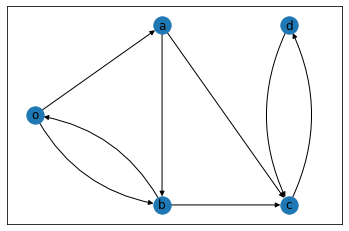

In [23]:
# new graph which removes from graph G the nodes (c,b) and (d,a)
G_new2 = nx.DiGraph()
G_new2.add_edges_from([('o','a'),('o','b'),('a','b'),('a','c'),('b','o'),('b','c'),('c','d'),('d','c')])
pos = {'o':[-1,0], 'a':[0,1], 'b':[0,-1], 'd':[1,1], 'c':[1,-1]}



fig_1_8, ax_new2 = plt.subplots()
nx.draw_networkx_nodes(G_new2, pos, ax=ax_new2)
nx.draw_networkx_labels(G_new2, pos, ax=ax_new2)
curved_edges2 = [edge for edge in G_new2.edges() if reversed(edge) in G_new2.edges()]
straight_edges2 = list(set(G_new2.edges()) - set(curved_edges2))
nx.draw_networkx_edges(G_new2, pos, ax=ax_new2, edgelist=straight_edges2)
arc_rad = 0.25
nx.draw_networkx_edges(G_new2, pos, ax=ax_new2, edgelist=curved_edges2, connectionstyle=f'arc3, rad = {arc_rad}')

#fig_1_8.savefig("Exercise1_h.png")

In [24]:
# check if aperiodic
nx.is_aperiodic(G_new2)

True

In [25]:
# check if strongly connected
nx.is_strongly_connected(G_new2)

False

{'c': 0, 'd': 0, 'b': 1, 'o': 1, 'a': 1}

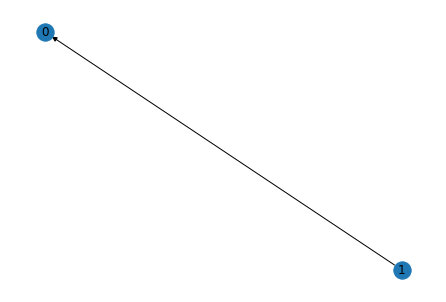

In [27]:
# draw the condensation graph
CG2 = nx.algorithms.components.condensation(G_new2)

nx.draw(CG2, with_labels = True)

# obtain info related to the mapping 
CG2.graph['mapping']

#plt.savefig("Condensategraph1_h.png", format="PNG")

From the mapping we can see that c and d are the sink component and actually the sink is not aperiodic

In [28]:
Lambda_new2 = [
[0, 2/5, 1/5, 0, 0 ],
[0, 0, 3/4, 1/4, 0 ],
[1/2, 0, 0, 1/2, 0 ],
[0, 0, 0, 0 ,2/3 ],
[0, 0, 0, 1/3, 0 ]]

w_new2 = np.sum(Lambda_new2, axis=1)

D_new2 = np.diag(w_new2)
P_new2 = np.linalg.inv(D_new2) @ Lambda_new2
print(P_new2)

nstates = len(P_new2)

[[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.         0.         1.        ]
 [0.         0.         0.         1.         0.        ]]


In [29]:
# use P_new2 to run the French-De groot dynamics

x_init = np.array([1,0,1,1,0])
x = x_init
# simulate the French-De Groot dynamics for t = 100
for i in range(100):
    x = P_new2 @ x

print(f'the final result of the dynamics is : {x}')

# compute the dominant eigenvector 
values,vectors = np.linalg.eig(P_new2.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print(f'the invariant distribution of G is : {pi_bar}')
# compute the theoretical value as cited by the theorem
print(f'theorical value alpha : {pi_bar @ x_init.T}')

the final result of the dynamics is : [0.53846154 0.57692308 0.23076923 1.         0.        ]
the invariant distribution of G is : [1.45039892e-16 2.98634560e-16 3.78929145e-16 5.00000000e-01
 5.00000000e-01]
theorical value alpha : 0.5000000000000003


In [30]:
# use P_new2 to run the French-De groot dynamics

x_init = np.array([0,0,0,1,0])
x = x_init
# simulate the French-De Groot dynamics for t = 100
for i in range(100):
    x = P_new2 @ x

print(f'the final result of the dynamics is : {x}')

# compute the dominant eigenvector 
values,vectors = np.linalg.eig(P_new2.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print(f'the invariant distribution of G is : {pi_bar}')
# compute the theoretical value as cited by the theorem
print(f'theorical value alpha : {pi_bar @ x_init.T}')

the final result of the dynamics is : [0.53846154 0.57692308 0.23076923 1.         0.        ]
the invariant distribution of G is : [1.45039892e-16 2.98634560e-16 3.78929145e-16 5.00000000e-01
 5.00000000e-01]
theorical value alpha : 0.4999999999999998


In [31]:
# use P_new2 to run the French-De groot dynamics

x_init = np.array([0,1,1,0,1])
x = x_init
# simulate the French-De Groot dynamics for t = 100
for i in range(100):
    x = P_new2 @ x

print(f'the final result of the dynamics is : {x}')

# compute the dominant eigenvector 
values,vectors = np.linalg.eig(P_new2.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print(f'the invariant distribution of G is : {pi_bar}')
# compute the theoretical value as cited by the theorem
print(f'theorical value alpha : {pi_bar @ x_init.T}')

the final result of the dynamics is : [0.46153846 0.42307692 0.76923077 0.         1.        ]
the invariant distribution of G is : [1.45039892e-16 2.98634560e-16 3.78929145e-16 5.00000000e-01
 5.00000000e-01]
theorical value alpha : 0.5000000000000001


In [32]:
# use P_new2 to run the French-De groot dynamics

x_init = np.array([0,1,1,1,1])
x = x_init
# simulate the French-De Groot dynamics for t = 100
for i in range(100):
    x = P_new2 @ x

print(f'the final result of the dynamics is : {x}')

# compute the dominant eigenvector 
values,vectors = np.linalg.eig(P_new2.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print(f'the invariant distribution of G is : {pi_bar}')
# compute the theoretical value as cited by the theorem
print(f'theorical value alpha : {pi_bar @ x_init.T}')

the final result of the dynamics is : [1. 1. 1. 1. 1.]
the invariant distribution of G is : [1.45039892e-16 2.98634560e-16 3.78929145e-16 5.00000000e-01
 5.00000000e-01]
theorical value alpha : 0.9999999999999999


Since the globally reachable component is periodic of period = 2, we cannot guarantee convergence.  In fact we can see that there's no convergence toward the invariant distribution. Opinion of the agents not belonging to the globally reachable component have no influence on the final value. 
We also notices that consensus is met only when all the nodes in the globally reachable component have the same opinion. otherweise we do not have consensus 

### Exercise 2

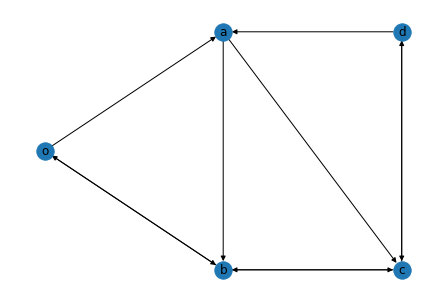

In [33]:
#same graph as exercise 1
G_labelled = nx.DiGraph()
G_labelled.add_edges_from([('o','a'),('o','b'),('a','b'),('a','c'),('b','o'),('b','c'),('c','b'),('c','d'),('d','a'),('d','c')])
pos = {'o':[-1,0], 'a':[0,1], 'b':[0,-1], 'd':[1,1], 'c':[1,-1]}

nx.draw(G_labelled,pos, with_labels = True)

In [34]:
mapping = {'o': 0, 'a':1 , 'b':2, 'c':3 ,'d':4}
G = nx.relabel_nodes(G_labelled, mapping)

Lambda = [
[0, 2/5, 1/5, 0, 0 ],
[0, 0, 3/4, 1/4, 0 ],
[1/2, 0, 0, 1/2, 0 ],
[0, 0, 1/3, 0 ,2/3 ],
[0, 1/3, 0, 1/3, 0 ]]

# compute normalized weight matrix P
w = np.sum(Lambda, axis=1)
D = np.diag(w)
P = np.linalg.inv(D) @ Lambda

nstates = len(Lambda)
n_nodes = len(Lambda)

### exercise 2.a particle prospective

In [36]:
# Compute the jump chain matrix Q
w = np.sum(Lambda, axis=1)
# print(w)
w_star = np.max(w)
# compute the off-diagonal part of Q
Q = Lambda/w_star 
# add the diagonal part
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))
# print(Q)

In [37]:
# global clock with rate 100 and matrix Q
# high level implementation described in the report

rate = 100
n_particles = 100
global_time = 0
# set the number of steps in the simulation
n_steps = 20000
# pos will keep trace of the visited states -> set initial state to -1
pos = -np.ones((n_particles,n_steps), dtype=int)

# all the particles start from position 1 which corresponds to node a 
pos[:,0] = 1
# print(f'position matrix : \n{pos}')
# transition_times will store the time instants at which
# jumps/transitions happen, one for each particle
transition_times = np.zeros((n_particles,n_steps))
# the random time to wait for the next transition
# is drawn according to the hint provided for exercise 2
t_next = -np.log(np.random.rand())/rate
# print(f'clock time : {t_next}')

for i in range(1,n_steps):
    # select randomly a particle over all the 100
    particle = random.randint(0, n_particles -1) # (because index starts from zero to 99)

    
    # retrieve the first -1 index -> it will be used to store exactly the next position
    index = np.where(pos[particle,:] == -1)[0][0]

    
    # the next state to visit will be extracted according to the probabilities
    # stored in the row of Q corresponding to the current state.
    # In general, to extract a value pos[i] in (0,...,num_states-1) according to the discrete
    # distribution Q[pos[i-1],:]
    pos[particle][index] = np.random.choice(nstates, p=Q[pos[particle][index-1],:])

    # update global time
    global_time += t_next
    
    # record the time used by the selected particle to arrive in the node
    transition_times[particle][index-1] = global_time

    # compute the waiting time to the next transition    
    t_next = -np.log(np.random.rand())/rate

    


# Estimate pi


pi_estimate = np.zeros((n_particles,nstates))

for part in range(n_particles):
    # retrieve the first index where transition time is zero (in order to consider only the non zero times to compute the intervals)
    index = np.argwhere(transition_times[part]==0)
    times = np.delete(transition_times[part], index)
    
    # We have the time instants of all transitions, we now compute time intervals.
    # np.diff computes the n-th discrete difference of a vector.
    # Here we set n=1 to compute first difference, which is given by 
    # intervals[i] = transition_times[i+1] - transition_times[i].
    # We also provide a value to  append to transition_times prior to performing the difference
    # so that we can compute also the last interval: 
    # transition_times[-1] + t_next is the end of the time horizon.
    intervals = np.diff(times, n=1, append = global_time + t_next)

    # for each state in the state space
    for state in range(nstates):
        # identify the steps when we visited that state during the process
        visits = np.argwhere(pos[part] == state)
        if visits.size != 0 :

        # the estimate of the invariant measure for that state is equal to the
        # time spent on the state divided the total time of the process
            pi_estimate[part][state] = np.sum(intervals[visits-1])/(global_time + t_next)
        else:
            pi_estimate[part][state] = 0
    
pi_estimate = pi_estimate.mean(axis = 0)
print("Estimate of pi_bar:\n", pi_estimate)
print(f'estimate of return time in node a is : {1/(w[1]*pi_estimate[1])}')
print(f'global_time : {global_time}')

Estimate of pi_bar:
 [0.17627055 0.15225568 0.22153252 0.2230268  0.22715185]
estimate of return time in node a is : 6.567899590814534
global_time : 200.33516083921322


In [38]:
# compute dominant eigenvector
values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

nstates = len(pi_bar)
print(f'exact calculation of return time in node a is :{1/(w[1]*pi_bar[1])}')

pi_bar= [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]
exact calculation of return time in node a is :6.750000000000008


### Exercise 2.b : node prospective

In [39]:
# global clock with rate 100 and matrix Q
# high level implementation described in the report
rate = 100
n_particles = 100

# number of simulations
simulations = 100
# keeps the global time for each of the simulations
global_time = np.zeros(simulations)


# node will keep trace of the quantity of particles in each node 
node = np.zeros((simulations,n_nodes), dtype=int)


# all the particles start from position 0 which corresponds to node o 
node[:,0] = n_particles

for s in range(simulations):
    
    # the random time to wait for the next transition
    # with rate = 100
    t_next = -np.log(np.random.rand())/rate
    
    while global_time[s] < 60:

        # the prob of choosing a node depends on the number
        # of particles in that node
        node_prob = np.array([i/n_particles for i in node[s]])
        
        # the next node to visit is computed according to the 
        # probability previously computed
        start_node = np.random.choice(n_nodes, p=node_prob)

        # the next state to visit will be extracted according to the probabilities
        # stored in the row of Q corresponding to the current state start_node
        end_node = np.random.choice(n_nodes, p=Q[start_node,:])

        # update the number of nodes 
        node[s][start_node] -= 1
        node[s][end_node] += 1

        # update the global_time
        global_time[s] += t_next

        # compute next time
        t_next = -np.log(np.random.rand())/rate


result = node
print(f'the average number of particles in each node is : \n{result.mean(axis = 0)}')


the average number of particles in each node is : 
[18.5  15.44 21.98 21.79 22.29]


In [40]:
average = result.mean(axis = 0)
res = average/(average.sum())
print(res)

[0.185  0.1544 0.2198 0.2179 0.2229]


Despite taking a lot of time for computation, we can notice that with great number of simulations, this converges to the stationary distribution

In [41]:
# compute dominant eigenvector
values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print(f"stationary distribution :\n{pi_bar}")

nstates = len(pi_bar)

stationary distribution :
[0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]


*GRAPH DRAW* 

last position of the nodes are : 
[17 10 29 25 19]


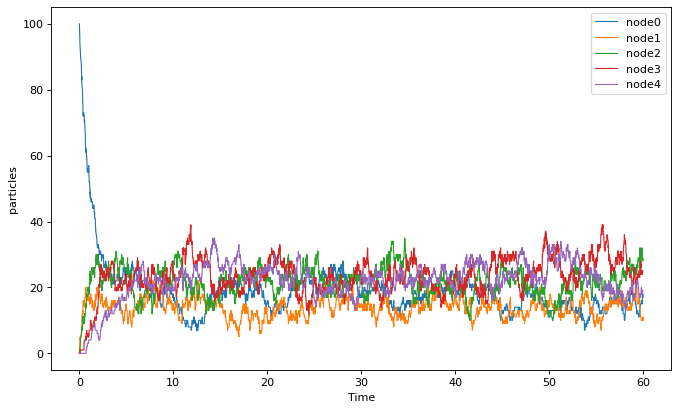

In [44]:
# for one simulation

rate = 100
n_particles = 100

time = np.zeros(1)
global_time = 0

# node will keep trace of the quantity of particles in each node 
node = np.zeros((n_nodes,1) , dtype=int)

counter = 0 #counts the number of ticks 
# all the elements start from position 0 which corresponds to node o 
node[0][0] = n_particles

# the random time to wait for the next transition
# with rate = 100
t_next = -np.log(np.random.rand())/rate
#line graph of one simulation 
while global_time < 60:
        
        # create a copy of the node 
        new_node = np.copy(node[:,counter]).reshape(5,1)
        
        # the prob of choosing a node depends on the number
        # of particles in that node
        node_prob = np.array([i/n_particles for i in node[:,counter]])
        
        # the next node to visit is computed according to the 
        # probability previously computed
        start_node = np.random.choice(n_nodes, p=node_prob)

        # the next state to visit will be extracted according to the probabilities
        # stored in the row of Q corresponding to the current state start_node
        end_node = np.random.choice(n_nodes, p=Q[start_node,:])

        # update the number of nodes 
        new_node[start_node] -= 1
        new_node[end_node] += 1
        
        # update the global_time
        global_time += t_next
        new_time = np.ones(1)*global_time
        time = np.concatenate((time,new_time))

        counter = counter + 1
        
        node = np.concatenate((node, new_node), axis = 1)
        
        # compute next time
        t_next = -np.log(np.random.rand())/rate

fig = plt.figure(figsize=(10, 6), dpi=80) 
for i in range(n_nodes):
    plt.plot(time,node[i], label = f'node{i}', linewidth = 1)
plt.legend()
plt.xlabel('Time')
plt.ylabel('particles')



#plt.savefig('exercise2nodesimulation')


print(f'last position of the nodes are : \n{node[:,-1]}')

### Exercise 3

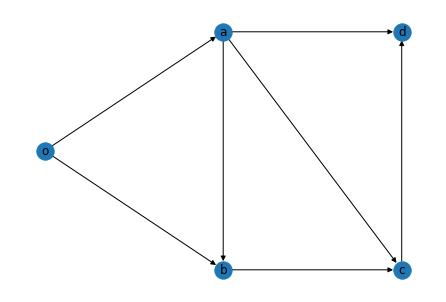

In [67]:
Lambda_open = [
    [0, 3/4, 3/8, 0, 0],
    [0, 0, 1/4, 1/4,2/4],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0]
]

G = nx.DiGraph()
G.add_edges_from([('o', 'a'), ('o','b'),('a','b'),('a','c'),('a','d'),('b','c'),('c','d')])

pos = {'o':[-1,0], 'a':[0,1], 'b':[0,-1], 'd':[1,1], 'c':[1,-1]}

nx.draw(G, pos, with_labels = True)

In [68]:
# compute jump matrix Q

w = np.sum(Lambda_open, axis=1)
w_star = np.max(w)
# compute the off-diagonal part of Q
Q = Lambda_open/w_star 
# add the diagonal part
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))

n_nodes = len(Lambda_open)

### exercise 3.1 proportional rate

Simulate the system for 60 time units and plot the evolution of the number of particles in each node over time

Text(0, 0.5, 'particles')

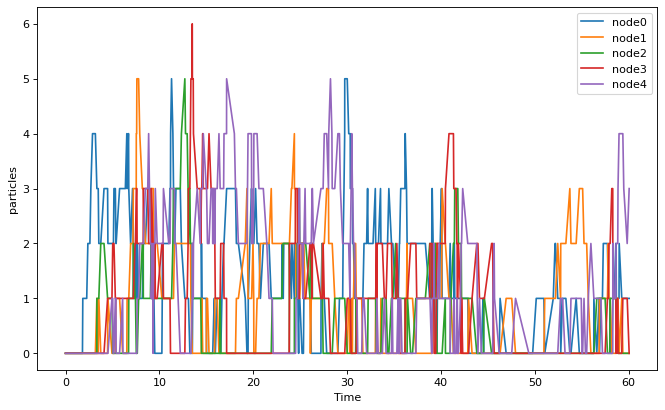

In [70]:
input_rate = 1
out_rate = 2

global_clock = np.zeros(1)
global_time = 0

node_clock = np.zeros(n_nodes+1) # adding the one that gives particles to the graph

node = np.zeros((n_nodes,1) , dtype=int)

counter = 0 #counts the number of ticks 

#starting configuration
for i in range(n_nodes - 1):
    if node[i][counter] == 0:
        node_clock[i] = np.inf
    else:
        node_clock[i] = -np.log(np.random.rand())/(node[i][counter]*w[i])
node_clock[-2] = -np.log(np.random.rand())/out_rate + global_time
node_clock[-1] = -np.log(np.random.rand())/input_rate + global_time


while global_time < 60:
        
        new_node = np.copy(node[:,counter]).reshape(5,1)
        
        # retrieve the index of the minimum clock value 
        index = np.argmin(node_clock)
        
        # set this value as global_time
        global_time = node_clock[index]
        
        if index == 5: # new particle incoming
            new_node[0] += 1
            
            node_clock[index] = -np.log(np.random.rand())/input_rate + global_time
            node_clock[0] = -np.log(np.random.rand())/(new_node[0]*w[0]) + global_time
            
        elif index == 4: # particle outgoing from the system
            if new_node[index] > 0:
                new_node[index] -= 1

            node_clock[index] = -np.log(np.random.rand())/out_rate + global_time
            
                
        
        else: # index = 0, 1, 2, 3 -> we have a movement in the graph of a particle
            if new_node[index] > 0:
                destination = np.random.choice(n_nodes, p=Q[index,:])
                new_node[index] -= 1
                new_node[destination] += 1

                if new_node[index] == 0:
                    node_clock[index] = np.inf
                else:
                    node_clock[index] = -np.log(np.random.rand())/(new_node[index]*w[index]) + global_time
                if destination != 4:
                    node_clock[destination] = -np.log(np.random.rand())/(new_node[destination]*w[destination]) + global_time
        #update time and global_clock      
        new_time = np.ones(1)*global_time
        global_clock = np.concatenate((global_clock,new_time))

        counter = counter + 1
        node = np.concatenate((node, new_node), axis = 1)

        
            

fig = plt.figure(figsize=(10, 6), dpi=80) 
for i in range(n_nodes):
    plt.plot(global_clock,node[i], label = f'node{i}')
plt.legend()
plt.xlabel('Time')
plt.ylabel('particles')

# fig2 = plt.figure(figsize=(10, 4), dpi=80) 
# for i in range(n_nodes):
#     plt.plot(np.arange(counter+1),node[i], label = f'node{i}')
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('particles')

#plt.savefig('exercise3proportionalrate')


# print(f'last position of the nodes are : \n{node[:,-1]}')

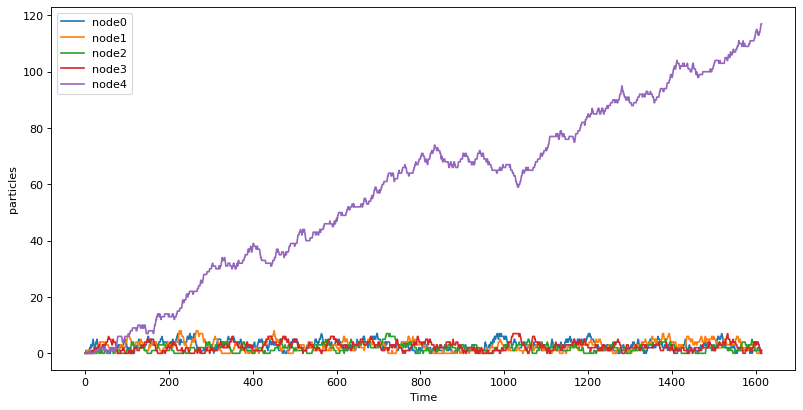

In [71]:
input_rate = 3
out_rate = 2

global_clock = np.zeros(1)
global_time = 0

node_clock = np.zeros(n_nodes+1) # adding the one that gives particles to the graph

node = np.zeros((n_nodes,1) , dtype=int)

counter = 0 #counts the number of ticks 

#starting configuration
for i in range(n_nodes - 1):
    if node[i][counter] == 0:
        node_clock[i] = np.inf
    else:
        node_clock[i] = -np.log(np.random.rand())/(node[i][counter]*w[i])
node_clock[-2] = -np.log(np.random.rand())/out_rate + global_time
node_clock[-1] = -np.log(np.random.rand())/input_rate + global_time


while global_time < 120:
        
        
        new_node = np.copy(node[:,counter]).reshape(5,1)
        index = np.argmin(node_clock)
        global_time = node_clock[index]

        
        
        if index == 5: # new particle incoming
            new_node[0] += 1
            

            
            node_clock[index] = -np.log(np.random.rand())/input_rate + global_time
            node_clock[0] = -np.log(np.random.rand())/(new_node[0]*w[0]) + global_time
            
        elif index == 4: # particle outgoing from the system
            if new_node[index] > 0:
                new_node[index] -= 1
                


            node_clock[index] = -np.log(np.random.rand())/out_rate + global_time
            
                
        
        else: # index = 0, 1, 2, 3 -> we have a movement in the graph of a particle
            if new_node[index] > 0:
                destination = np.random.choice(n_nodes, p=Q[index,:])
                new_node[index] -= 1
                new_node[destination] += 1
                

                if new_node[index] == 0:
                    node_clock[index] = np.inf
                else:
                    node_clock[index] = -np.log(np.random.rand())/(new_node[index]*w[index]) + global_time
                if destination != 4:
                    node_clock[destination] = -np.log(np.random.rand())/(new_node[destination]*w[destination]) + global_time
              
        new_time = np.ones(1)*global_time
        global_clock = np.concatenate((global_clock,new_time))

        counter = counter + 1
        node = np.concatenate((node, new_node), axis = 1)


fig2 = plt.figure(figsize=(12, 6), dpi=80) 
for i in range(n_nodes):
    plt.plot(np.arange(counter+1),node[i], label = f'node{i}')
plt.legend()
plt.xlabel('Time')
plt.ylabel('particles')

plt.savefig('exercise3blowup')


# print(global_clock)
# print(f'last position of the nodes are : \n{node[:,-1]}')

### exercise 3.2 fixed rate

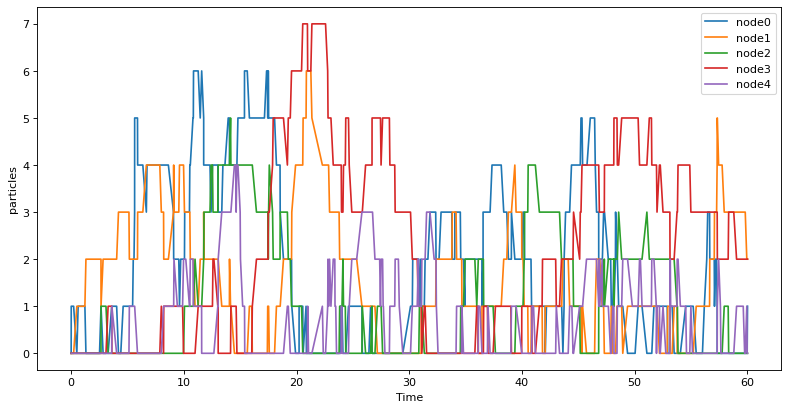

In [80]:
input_rate = 1
out_rate = 2

global_clock = np.zeros(1)
global_time = 0

node_clock = np.zeros(n_nodes+1) # adding the one that gives particles to the graph

node = np.zeros((n_nodes,1) , dtype=int)

counter = 0 #counts the number of ticks 

#starting configuration
for i in range(n_nodes - 1):    
    node_clock[i] = -np.log(np.random.rand())/(w[i])
node_clock[-2] = -np.log(np.random.rand())/out_rate + global_time
node_clock[-1] = -np.log(np.random.rand())/input_rate + global_time


while global_time < 60:
        
        new_node = np.copy(node[:,counter]).reshape(5,1)
        index = np.argmin(node_clock)
        global_time = node_clock[index]

        
        
        if index == 5: # new particle incoming
            new_node[0] += 1
            

            
            node_clock[index] = -np.log(np.random.rand())/input_rate + global_time

            
        elif index == 4: # particle outgoing from the system
            if new_node[index] > 0:
                new_node[index] -= 1
                


            node_clock[index] = -np.log(np.random.rand())/out_rate + global_time
            
                
        
        else: # index = 0, 1, 2, 3 -> we have a movement in the graph of a particle
            if new_node[index] > 0:
                destination = np.random.choice(n_nodes, p=Q[index,:])
                new_node[index] -= 1
                new_node[destination] += 1


                node_clock[index] = -np.log(np.random.rand())/(w[index]) + global_time

            else:
                node_clock[index] = -np.log(np.random.rand())/(w[index]) + global_time
            
        new_time = np.ones(1)*global_time
        global_clock = np.concatenate((global_clock,new_time))

        counter = counter + 1
        node = np.concatenate((node, new_node), axis = 1)


fig2 = plt.figure(figsize=(12, 6), dpi=80) 
for i in range(n_nodes):
    plt.plot(global_clock,node[i], label = f'node{i}')
plt.legend()
plt.xlabel('Time')
plt.ylabel('particles')

plt.savefig('exercise3fixedrate')

# print(global_clock)
# print(f'last position of the nodes are : \n{node[:,-1]}')

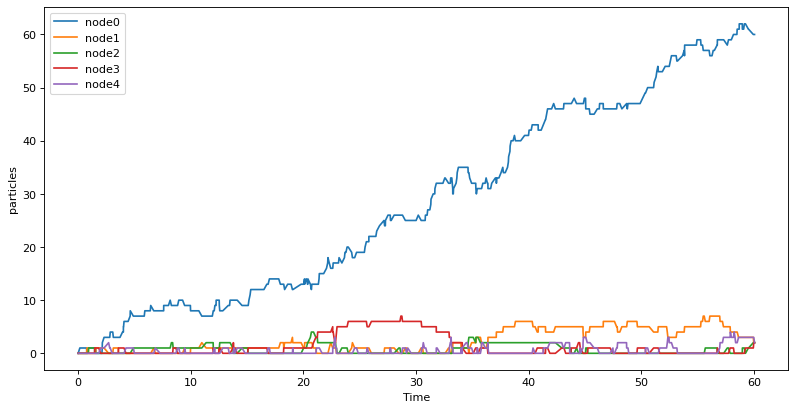

In [82]:
input_rate = 2
out_rate = 2

global_clock = np.zeros(1)
global_time = 0

node_clock = np.zeros(n_nodes+1) # adding the one that gives particles to the graph

node = np.zeros((n_nodes,1) , dtype=int)

counter = 0 #counts the number of ticks 

#starting configuration
for i in range(n_nodes - 1):    
    node_clock[i] = -np.log(np.random.rand())/(w[i])
node_clock[-2] = -np.log(np.random.rand())/out_rate + global_time
node_clock[-1] = -np.log(np.random.rand())/input_rate + global_time


while global_time < 60:
        
        new_node = np.copy(node[:,counter]).reshape(5,1)
        index = np.argmin(node_clock)
        global_time = node_clock[index]

        
        
        if index == 5: # new particle incoming
            new_node[0] += 1
            

            
            node_clock[index] = -np.log(np.random.rand())/input_rate + global_time

            
        elif index == 4: # particle outgoing from the system
            if new_node[index] > 0:
                new_node[index] -= 1
                


            node_clock[index] = -np.log(np.random.rand())/out_rate + global_time
            
                
        
        else: # index = 0, 1, 2, 3 -> we have a movement in the graph of a particle
            if new_node[index] > 0:
                destination = np.random.choice(n_nodes, p=Q[index,:])
                new_node[index] -= 1
                new_node[destination] += 1


                node_clock[index] = -np.log(np.random.rand())/(w[index]) + global_time

            else:
                node_clock[index] = -np.log(np.random.rand())/(w[index]) + global_time
            
        new_time = np.ones(1)*global_time
        global_clock = np.concatenate((global_clock,new_time))

        counter = counter + 1
        node = np.concatenate((node, new_node), axis = 1)


fig2 = plt.figure(figsize=(12, 6), dpi=80) 
for i in range(n_nodes):
    plt.plot(global_clock,node[i], label = f'node{i}')
plt.legend()
plt.xlabel('Time')
plt.ylabel('particles')

plt.savefig('exercise3fixedrate')

# print(global_clock)
# print(f'last position of the nodes are : \n{node[:,-1]}')